In [12]:
from sklearn import datasets
import warnings
import optuna
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_classification
import shap
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from pymoo.factory import get_performance_indicator
from optuna.exceptions import TrialPruned
import miceforest as mf
from autocluster.autohypothesis import autohypothesis_utils

In [13]:
emploi_df = pd.read_csv('emploi_62.csv').drop(columns=["brsa_clep"])
#emploi_df = pd.read_csv('emploi_62.csv').drop(columns=["brsa_clep","age"])
emploi_df.rename(columns={"duree_rsa_annee": "target"}, inplace=True)

In [14]:
def split_responses(df, column_name):
    # Get unique modes of transport from the column by splitting by ', '
    modes = set()
    for row in df[column_name].dropna():
        modes.update(row.split(", "))

        # Create a new column for each mode and set to False by default
    for mode in modes:
        df[mode] = False

    # Iterate over the rows and update the corresponding mode columns to True if the mode is mentioned
    for index, row in df.iterrows():
        if pd.notna(row[column_name]):
            for mode in row[column_name].split(", "):
                df.at[index, mode] = True    

    # Drop the original column
    df.drop(columns=[column_name], inplace=True)   

    return df

# Apply the function to the dataframe
emploi_df = split_responses(emploi_df, "Selon_vous__avez-vous_des_freins_à_l'emploi_?__plusieurs_réponses_possibles_")
emploi_df = split_responses(emploi_df, "Que_pensez-vous_de_votre_logement_?__plusieurs_réponses_possibles_")
emploi_df = split_responses(emploi_df, "Comment_vous_déplacez-vous__dans_votre_quotidien_?__plusieurs_réponses_possibles_")


In [15]:
df =emploi_df

In [16]:
category_mappings = {}

for column in df.columns:
    if df[column].dtype == 'object':
        # Convertir la colonne en type 'category' et enregistrer le mappage
        df[column] = df[column].astype('category')
        # Enregistre le mappage de la catégorie vers le code
        category_mappings[column] = dict(enumerate(df[column].cat.categories))
        # Encodage des catégories en entiers
        df[column] = df[column].cat.codes.replace(-1, np.nan)




In [17]:

# Create kernel. 
kds = mf.ImputationKernel(
  df,
  save_all_iterations=True,
  random_state=100
)

# Run the MICE algorithm for 2 iterations
kds.mice(10)

# Return the completed dataset.
df_imputed = kds.complete_data()



In [18]:

for column in df_imputed.columns:
    if column in category_mappings:
        df_imputed[column] = df_imputed[column].map(category_mappings[column])

df_imputed

,Qui_gère_le_budget_à_la_maison_?,Comment_faites-vous_pour_gérer_votre_budget_?,Avez-vous_des_crédits_en_cours_?_,Avez-vous_des_difficultés_concernant_votre_budget_?,Y_a-t-il_des_éléments_que_vous_souhaiteriez_aborder_concernant_votre_budget_?,Exercez-vous_une_activité_professionnelle_?_,Recherchez-vous_un_emploi_?,Avez-vous_une_expérience_professionnelle_?,Quel_est_votre_parcours_de_formation__votre_niveau_de_diplôme_?,Etes-vous_à_l'aise_avec_l'outil_informatique_?,...,Trop grand,Trop petit,Mauvais état,Bruyant,À pied,Accompagné,En voiture,En transports en commun,En 2 roues,Co-voiturage
0,Je gère mon budget,Je paie mes factures au fur et à mesure,False,Aucune difficulté,False,Non,False,True,Niveau 3 : CAP/BEP,Oui,...,False,False,False,False,False,False,True,False,False,False
1,Je gère mon budget,Je vis au jour le jour,False,Aucune difficulté,False,Non,False,True,CAP/BEP (non obtenu),"Non, je n'en ai pas besoin",...,False,False,False,False,True,False,False,False,False,False
2,Je gère mon budget,Je mets de l'argent de côté,False,Aucune difficulté,False,Non,False,False,CAP/BEP (non obtenu),Oui,...,False,False,False,False,True,False,False,True,False,False
3,Je gère mon budget,J'ai toujours du retard dans le paiement de me...,False,Aucune difficulté,False,Non,False,True,Niveau 4 : BAC ou équivalent,Oui,...,False,False,True,False,False,False,True,False,False,False
4,Je gère mon budget,J'anticipe les entrées et sorties d'argent,False,Aucune difficulté,False,Non,False,True,Fin de scolarité obligatoire,Non,...,False,False,False,False,False,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,Gestion commune,J'anticipe les entrées et sorties d'argent,False,J'ai des difficultés à terminer le mois,False,CDD,True,True,CAP/BEP (non obtenu),Oui,...,False,False,False,False,False,False,False,True,False,False
1460,Je gère mon budget,Je paie mes factures au fur et à mesure,False,J'ai des difficultés à terminer le mois,False,Non,True,False,CAP/BEP (non obtenu),Oui,...,False,False,True,False,True,False,False,False,False,False
1461,Je gère mon budget,J'anticipe les entrées et sorties d'argent,False,Aucune difficulté,True,Non,True,True,Niveau 4 : BAC ou équivalent,Oui,...,False,False,False,False,True,False,False,True,False,False
1462,Gestion commune,Je paie mes factures au fur et à mesure,True,J'ai des difficultés à terminer le mois,True,Non,True,True,Niveau 6 : études supérieures,Non,...,False,False,True,False,True,False,True,True,False,False


In [19]:

non_ordinal_columns = [column for column in df_imputed.columns if df_imputed[column].dtype == 'object']

# Applique le one-hot encoding seulement aux colonnes non ordinales
df_imputed = pd.get_dummies(df_imputed, columns=non_ordinal_columns, drop_first=True)


In [20]:
df_imputed

,Avez-vous_des_crédits_en_cours_?_,Y_a-t-il_des_éléments_que_vous_souhaiteriez_aborder_concernant_votre_budget_?,Recherchez-vous_un_emploi_?,Avez-vous_une_expérience_professionnelle_?,Avez-vous_une_formation_professionnelle_?,_Avez-vous_un/des_projet_s__personnel_s_/professionnel_s__dont_vous_souhaitez__me__faire_part_?,Avez-vous_des_loisirs/des_activités_?,Y_a-t-il_un_autre_élément_que_vous_souhaiteriez_aborder_concernant_votre_situation_familiale_?_,La_localisation_de_votre_logement_vous_convient-elle_?_,Votre_logement_est-il_adapté_à_vos_besoins_?_,...,role_personne_DEM,situation_familiale_Divorcé(e),situation_familiale_En concubinage,situation_familiale_Isolement après vie maritale ou Pacs,situation_familiale_Marié(e),situation_familiale_Pacsé(e),situation_familiale_Reprise vie maritale,situation_familiale_Séparation de fait,situation_familiale_Séparation légale,situation_familiale_Veuvage
0,False,False,False,True,False,False,True,False,True,True,...,True,True,False,False,False,False,False,False,False,False
1,False,False,False,True,True,False,False,False,True,False,...,True,False,False,True,False,False,False,False,False,False
2,False,False,False,False,False,False,True,False,True,True,...,True,False,False,False,False,False,False,False,False,False
3,False,False,False,True,True,False,False,False,True,False,...,True,False,False,False,False,False,False,True,False,False
4,False,False,False,True,False,False,False,False,True,True,...,True,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,False,False,True,True,False,True,True,True,True,True,...,True,False,False,False,False,False,True,False,False,False
1460,False,False,True,False,False,False,False,False,True,False,...,True,False,False,True,False,False,False,False,False,False
1461,False,True,True,True,True,False,True,False,True,False,...,True,False,False,False,False,False,False,False,False,False
1462,True,True,True,True,True,False,True,True,False,False,...,False,False,True,False,False,False,False,False,False,False


In [21]:
sk_iris = datasets.load_iris()
iris = pd.DataFrame(sk_iris['data'], columns=sk_iris['feature_names'])
iris['target'] = sk_iris['target']
sk_cancer = datasets.load_breast_cancer()
cancer = pd.DataFrame(sk_cancer['data'], columns=sk_cancer['feature_names'])
cancer['target'] = sk_cancer['target']
sk_wine = datasets.load_wine()
wine = pd.DataFrame(sk_wine['data'], columns=sk_wine['feature_names'])
wine['target'] = sk_wine['target']
star_df = pd.read_csv('star_classification.csv')
star_df.rename(columns={"class": "target"}, inplace=True)
star_df.drop(columns=['obj_ID',"fiber_ID","run_ID","rerun_ID","field_ID","spec_obj_ID","fiber_ID"], inplace=True)#,"redshift"
_, star_df = train_test_split(star_df, test_size=0.05, stratify=star_df['target'], random_state=42)


In [22]:
import pandas as pd
import numpy as np

# Initialisation de la liste pour stocker les résultats
results = []

# Nombre de runs
n_runs = 1  # Définissez n selon votre besoin

for run in range(n_runs):
    # Exécutez le code original
    #exp, X_train, X_dev, y_train, y_dev = opti_loop(iris, 200, norm="minmax", optimize_obj="solo")
    exp, X_train, X_dev, y_train, y_dev = autohypothesis_utils.opti_loop(df_imputed, 500,  optimize_obj="solo")
    all_objectives = np.array([trial.values for trial in exp.best_trials])
    sorted_objectives = all_objectives[np.argsort(all_objectives[:, 0])]
    params = autohypothesis_utils.get_trial_hyperparams(exp, trial_number=exp.best_trials[0].number)
    pipeline = autohypothesis_utils.rebuild_pipeline_with_hyperparams(params)
    pipeline.fit(X_train, y_train)
    acc = accuracy_score(y_dev, pipeline.predict(X_dev))
    entropy = autohypothesis_utils.clusterEntropy(pipeline, X_dev, pipeline.predict(X_dev))
    
    # Stockage des résultats pour cette itération
    results.append({
        "run_number": run + 1,
        "accuracy": acc,
        "entropy": 1 - entropy,
        "params": exp.best_trials[0].params
    })

# Création du DataFrame pour toutes les runs
df_runs = pd.DataFrame(results)

# Calcul de la moyenne des accuracies et entropies
avg_accuracy = np.mean(df_runs["accuracy"])
avg_entropy = np.mean(df_runs["entropy"])

# Création du DataFrame pour les moyennes
df_avg = pd.DataFrame([{
    "avg_accuracy": avg_accuracy,
    "avg_entropy": avg_entropy
}])

print(df_runs)
print(df_avg)


[I 2024-04-25 14:20:15,578] A new study created in memory with name: no-name-4aa830cf-2c7b-4ab7-a846-a0b43a965bed
[I 2024-04-25 14:20:16,276] Trial 0 finished with value: 0.6727272727272727 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 730, 'rf_max_depth': 22, 'rf_min_samples_split': 0.590079434775546, 'rf_min_samples_leaf': 0.013786732046248083, 'rf_max_features': 'log2', 'rf_random_state': 42}. Best is trial 0 with value: 0.6727272727272727.
[I 2024-04-25 14:20:17,225] Trial 1 finished with value: 0.6795454545454546 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 610, 'rf_max_depth': 12, 'rf_min_samples_split': 0.06493459917177226, 'rf_min_samples_leaf': 0.030662297233956234, 'rf_max_features': 'sqrt', 'rf_random_state': 42}. Best is trial 1 with value: 0.6795454545454546.
[I 2024-04-25 14:20:17,509] Trial 2 finished with value: 0.5 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 330, 'rf_max_depth': 7, 'rf_min_samples_split': 0

   run_number  accuracy   entropy  \
0           1  0.704545  0.633596   

                                              params  
0  {'classifier': 'RandomForest', 'rf_n_estimator...  
   avg_accuracy  avg_entropy
0      0.704545     0.633596


In [23]:
df_runs.to_csv("runs_solo_rsa_500.csv")
df_avg.to_csv("avg_solo_rsa_500.csv")

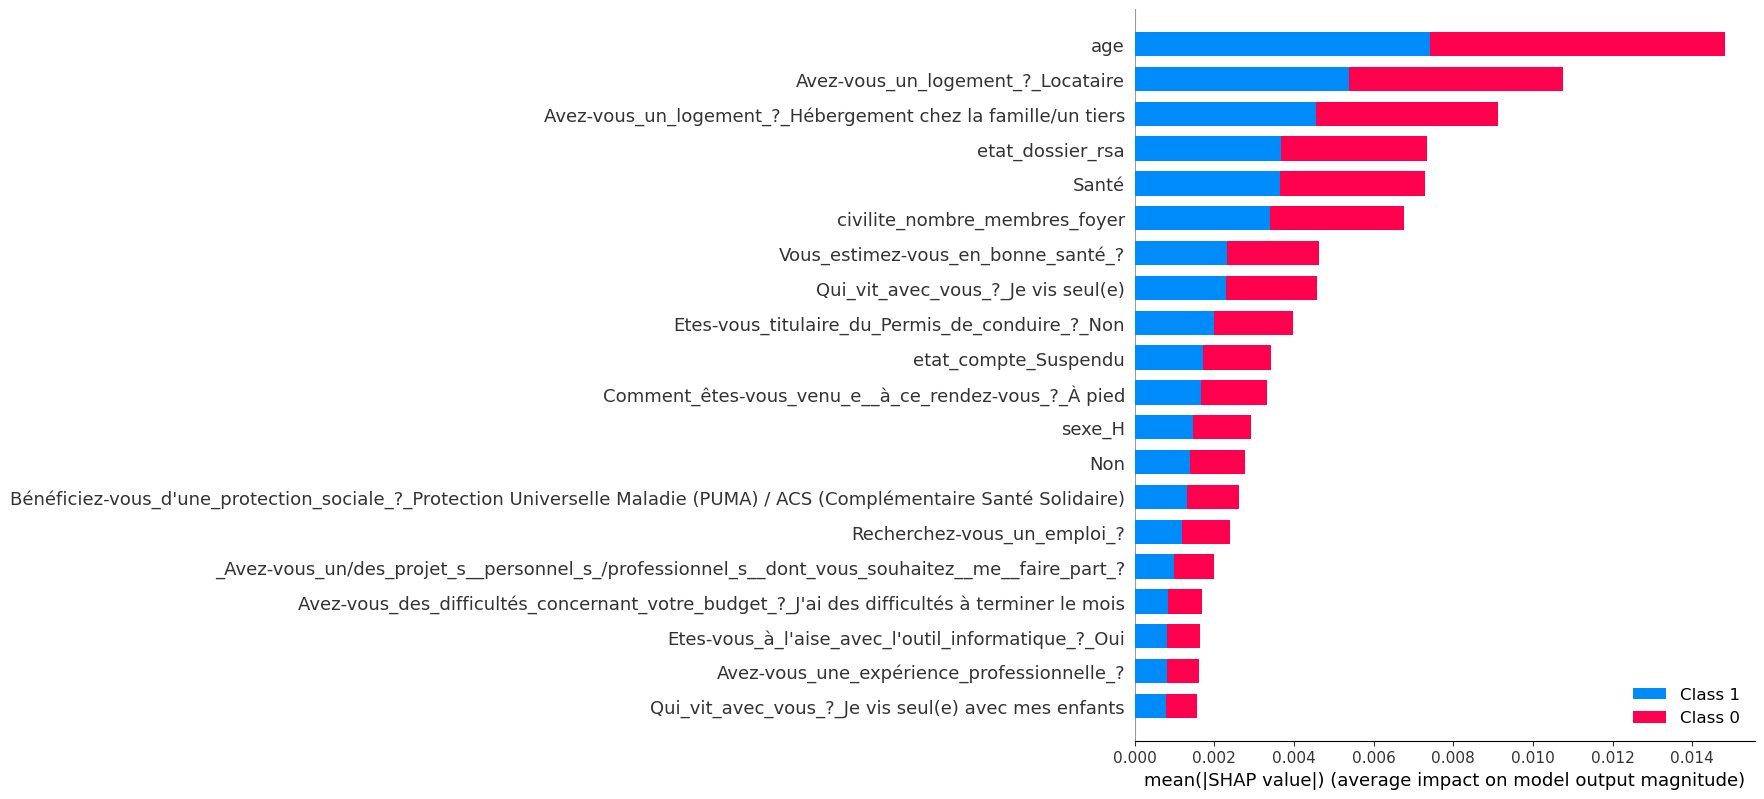

In [24]:
import shap

# Initialize your explainer
explainer = shap.TreeExplainer(pipeline.named_steps['classifier'])
explain_shap = explainer(X_dev)
# Compute SHAP values
shap_values = explainer.shap_values(X_dev)

# Summarize the SHAP values in a plot
shap.summary_plot(shap_values, X_dev)


In [25]:
vect = np.mean(np.abs(shap_values[1]), axis=0) 
I_c_minmax = (vect - np.min(vect)) / (np.max(vect) - np.min(vect))
sum_I_c_minmax = np.sum(I_c_minmax)
I_c_normalized = I_c_minmax / sum_I_c_minmax

In [26]:
vect

array([0.00000000e+00, 0.00000000e+00, 1.19596068e-03, 8.10205583e-04,
       2.49548811e-04, 9.89670149e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.38803484e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.30947711e-03, 0.00000000e+00,
       7.41262407e-03, 3.67309026e-03, 3.38640814e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.63943462e-03, 0.00000000e+00,
       1.38302542e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.58691028e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.22265069e-04, 0.00000000e+00, 2.84834691e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.74087360e-05,
       0.00000000e+00, 0.00000000e+00, 2.87020555e-05, 0.00000000e+00,
       4.26167215e-04, 0.00000000e+00, 8.39332758e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [27]:
I_c_normalized

array([0.        , 0.        , 0.02248813, 0.01523462, 0.00469237,
       0.01860917, 0.        , 0.        , 0.        , 0.00063707,
       0.        , 0.        , 0.        , 0.        , 0.04342603,
       0.        , 0.13938256, 0.0690666 , 0.063676  , 0.        ,
       0.        , 0.        , 0.06843376, 0.        , 0.02600558,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00029839, 0.        , 0.        , 0.        ,
       0.        , 0.00794002, 0.        , 0.00535586, 0.        ,
       0.        , 0.        , 0.        , 0.00070341, 0.        ,
       0.        , 0.0005397 , 0.        , 0.00801339, 0.        ,
       0.01578231, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00579664, 0.        , 0.00095272, 0.        , 0.        ,
       0.        , 0.        , 0.01539235, 0.0010939 , 0.00027838,
       0.        , 0.        , 0.04309604, 0.01470733, 0.     

In [28]:
import numpy as np

unique_classes = np.unique(y_dev)
random_ids = {}

for cls in unique_classes:
    # Obtenir les indices de toutes les instances de cette classe
    class_indices = np.where(y_dev == cls)[0]
    # Sélectionner aléatoirement un indice parmi ces indices
    random_id = np.random.choice(class_indices)
    random_ids[cls] = random_id

print(random_ids)


{0: 96, 1: 278}


In [29]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][random_ids[0]], X_dev.iloc[random_ids[0]])


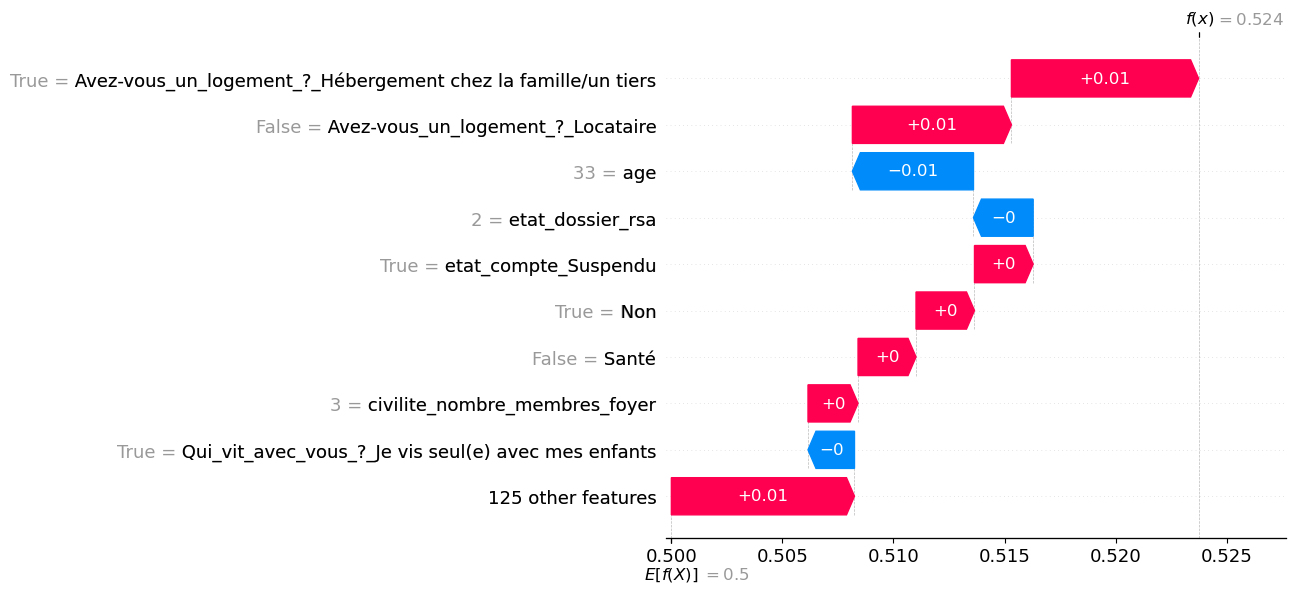

In [30]:
row = random_ids[0]
shap.waterfall_plot(shap.Explanation(values=shap_values[0][row], 
                                              base_values=explainer.expected_value[0], data=X_dev.iloc[row],  
                                         feature_names=X_dev.columns.tolist()))

In [31]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][random_ids[1]], X_dev.iloc[random_ids[1]])

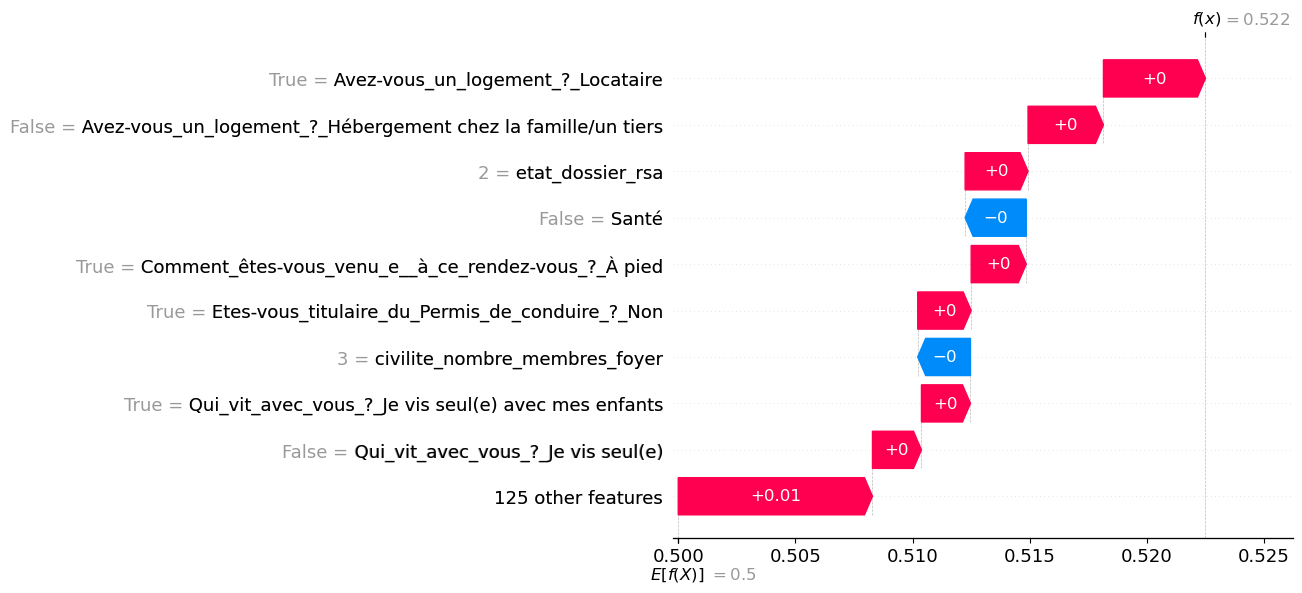

In [32]:
row = random_ids[1]
shap.waterfall_plot(shap.Explanation(values=shap_values[1][row], 
                                              base_values=explainer.expected_value[1], data=X_dev.iloc[row],  
                                         feature_names=X_dev.columns.tolist()))

In [33]:
shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][random_ids[2]], X_dev.iloc[random_ids[2]])

IndexError: index 2 is out of bounds for axis 0 with size 2

In [ ]:
row = random_ids[2]
shap.waterfall_plot(shap.Explanation(values=shap_values[2][row], 
                                              base_values=explainer.expected_value[2], data=X_dev.iloc[row],  
                                         feature_names=X_dev.columns.tolist()))